# Head volume vs cell volume for different cell cycle perturbations

In [1]:
from cellpose import models
from cellpose.io import imread
from skimage import io as skio
from skimage import measure, transform, morphology, filters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from parse import parse
import colorcet as cc
import os
import sys
from scipy import ndimage
from scipy import interpolate
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from aicsimageio import AICSImage
import aicsimageio
import xml.etree.ElementTree as ET
import seaborn as sns
import tifffile as tif
import pickle
plt.style.use("E:/Documents/Cohen Lab/bio_publications.mplstyle")

from aicsimageio.writers import OmeTiffWriter

In [2]:
rootdir = Path("E:/Documents/Cohen Lab/Papers/Kalki_CellCycle/20240116_phalloidin_head_volume_measurement")
expt_data = pd.DataFrame(columns=["genotype", "idx", "filename", "volume_um3", "voxel_size", "dx", "dz"])

In [3]:
def process_mask(img):
    ks_1 = 3
    ks_2 = 13
    kernel1 = morphology.disk(ks_1)[None,:,:]
    kernel2 = morphology.disk(ks_2)[None,:,:]
    # Add a border to the image to prevent edge effects
    volume_img = np.pad(img, [(0,0), (ks_2,ks_2), (ks_2,ks_2)], mode="constant")
    volume_img = ndimage.binary_closing(volume_img, structure=kernel1, iterations=1)
    volume_img = ndimage.median_filter(volume_img, size=(1,3,3))

    volume_img = ndimage.binary_dilation(volume_img, structure=kernel2, iterations=1)
    volume_img = ndimage.binary_fill_holes(volume_img)
    volume_img = ndimage.binary_erosion(volume_img, structure=kernel2, iterations=1)

    # remove the border
    volume_img = volume_img[:, ks_2:-ks_2, ks_2:-ks_2]
    return volume_img

In [4]:
def generate_tissue_mask(img, median_kernel_size=3, gaussian_sigma=5, bg_threshold=7):
    # Perform median and gaussian filtering to remove noise
    filtered = ndimage.median_filter(img, size=(1,median_kernel_size,median_kernel_size))
    filtered = ndimage.gaussian_filter(filtered, sigma=(0,gaussian_sigma,gaussian_sigma))
    # Get background mask
    background_mask = filtered < bg_threshold
    background_labels = measure.label(background_mask)
    # Get the largest background label
    background_label = np.argmax(np.bincount(background_labels.ravel())[1:]) + 1
    background_mask = background_labels == background_label
    tissue_mask = ~background_mask
    return tissue_mask

def write_imagej_file(img, filepath, dx=1, dz=1):
    with open("E:/Documents/Cohen Lab/Code/imagej_metadata_template.pkl", "rb") as f:
        imagej_metadata = pickle.load(f)

    imagej_metadata['images'] = np.prod(img.shape[:3])
    imagej_metadata['spacing'] = dz
    imagej_metadata['min'] = np.min(cell_labels)
    imagej_metadata['max'] = np.max(cell_labels)
    imagej_metadata['Ranges'] = (np.min(img[:,:,0,:,:]), np.max(img[:,:,0,:,:]), np.min(img[:,:,1,:,:]), np.max(img[:,:,1,:,:]))
    page_labels = []
    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            page_labels.append(f"c:{j+1}/{img.shape[2]}, z:{i+1}/{img.shape[1]} - Series0")
    imagej_metadata['Labels'] = page_labels
    imagej_metadata['Info'] = f"BitsPerPixel = 16\n DimensionOrder = XYCZT\n IsInterleaved = false\n IsRGB = false\n LittleEndian = true\n PixelType = uint16\n Series 0 Name = null\n SizeC = {img.shape[2]}\n SizeT = {img.shape[0]}\n SizeX = {img.shape[4]}\n SizeY = {img.shape[3]}\n SizeZ = {img.shape[1]}\n \Location = {filepath}"
    tif.imwrite(filepath, img, imagej=True, metadata=imagej_metadata, resolution=[1/dx, 1/dx])

def visualize_filtered_segments(genotype, idx):
    """
    Reconstruct the labels mask with only the cells that are within the size range
    """
    cell_labels = skio.imread(cell_seg_dir/f"{genotype}_E{idx}_membrane_predictions_{seg_method}.tiff")
    os.makedirs(rootdir/"analysis"/"filtered_masks", exist_ok=True)
    cell_sizes = cell_sizes_filtered.set_index(["genotype", "idx"]).loc[(genotype, idx)]
    print(len(np.unique(cell_labels)))
    cell_labels_filtered = cell_labels*np.isin(cell_labels, cell_sizes["label"])
    print(len(np.unique(cell_labels_filtered)))
    czi = AICSImage(rootdir/f"{genotype}_E{idx:d}_cell_volume.czi")
    mem_channel = [i for i, s in enumerate(czi.channel_names) if "AF555" in s][0]
    mem_img = czi.get_image_data("ZYXC", C=[mem_channel]).squeeze()
    metadata = czi.metadata.find("Metadata")
    scaling = metadata.find(".//Scaling")
    dx = float(scaling.find(".//Distance[@Id='X']").find("Value").text)*1e6
    dz = float(scaling.find(".//Distance[@Id='Z']").find("Value").text)*1e6

    filepath = str(rootdir/"analysis"/"filtered_masks"/f"{genotype}_E{idx:d}_filtered_mask_overlay.tif")
    img = np.zeros((1,cell_labels.shape[0],2,cell_labels.shape[1], cell_labels.shape[2]), dtype=np.uint16)
    img[0,:,0,:,:] = mem_img
    img[0,:,1,:,:] = cell_labels_filtered
    write_imagej_file(img, filepath, dx=dx, dz=dz)

## Generate tissue volume measurements
Threshold phalloidin signal and multiply by manually drawn area in 2D.

In [275]:
os.makedirs(rootdir/"processed_masks", exist_ok=True)
parse_fmt = "{genotype}_E{idx:d}.czi"
for f in os.listdir(rootdir):
    expt_info = parse(parse_fmt, f)
    if expt_info is None:
        continue
    expt_info = expt_info.named
    genotype = expt_info["genotype"]
    idx = expt_info["idx"]
    expt_info["filename"] = f
    if f in expt_data["filename"].values:
        print("Skipping", f)
        continue

    czi = AICSImage(rootdir/f)
    metadata = czi.metadata.find("Metadata")
    scaling = metadata.find(".//Scaling")
    dx = float(scaling.find(".//Distance[@Id='X']").find("Value").text)*1e6
    dz = float(scaling.find(".//Distance[@Id='Z']").find("Value").text)*1e6
    voxel_size = dz*dx*dx
    if f == "WT_E4.czi":
        img = skio.imread(rootdir/"WT_E4"/"WT_E4_fused.tif")
    else:
        img = czi.get_image_data("ZYX", S=0, T=0, C=0)
    tissue_mask = generate_tissue_mask(img)
    skio.imsave(rootdir/"processed_masks"/f"{genotype}_E{idx:d}_tissue_mask.tif", tissue_mask.astype(np.uint8)*255)
    manual_mask_boundary = skio.imread(rootdir/"manual_boundaries"/f"{genotype}_E{idx}_mask.tif") > 0
    volume = np.sum(tissue_mask*manual_mask_boundary)*voxel_size

    expt_info["volume_um3"] = volume
    expt_info["voxel_size"] = voxel_size
    expt_info["dx"] = dx
    expt_info["dz"] = dz
    
    expt_data = pd.concat([expt_data, pd.DataFrame([expt_info])])
    expt_data.to_csv(rootdir/"volume_data.csv", index=False)


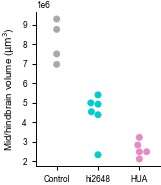

In [23]:
os.makedirs(rootdir/"analysis", exist_ok=True)
palette = ["#A9A9A9", "#00CDCD", "#E78AC3"]
# expt_data["volume_mm3"] = expt_data["volume_um3"]*1e-9
fig1, ax1 = plt.subplots(figsize=(1.6,2))
order = ["Control", "hi2648", "HUA"]
sns.swarmplot(data=expt_data.reset_index(), x="genotype", y="tissue_volume_um3", order=order, ax=ax1, palette=palette)
ax1.set_xlabel("")
ax1.set_ylabel(r"Mid/hindbrain volume ($\mathrm{\mu m}^3$)")
fig1.savefig(rootdir/"analysis"/"head_volume_swarmplot.svg")

## Clean up individual cell segmentations
Generated using PlantSeg

In [248]:
expt_data = pd.read_csv(rootdir/"volume_data.csv")
cell_seg_metadata = pd.read_csv(rootdir/"PlantSeg_Batch"/"experiment_info.csv").set_index(["genotype", "idx"])
seg_output_dir = "MutexWS_0.6_SP1000_minCell_14000"
cell_seg_dir = rootdir/"PlantSeg_Batch"/"PreProcessing"/"generic_confocal_3D_unet"/seg_output_dir/"PostProcessing"
seg_method = "gasp_mutex_watershed"
expt_data_by_sample = expt_data.set_index(["genotype", "idx"])
all_cell_sizes = pd.DataFrame()
for (genotype, idx), row in expt_data_by_sample.iterrows():
    cell_voxel_size = cell_seg_metadata.loc[(genotype, idx), "voxel_size"]
    cell_labels = skio.imread(cell_seg_dir/f"{genotype}_E{idx}_membrane_predictions_{seg_method}.tiff")
    cell_size_df = pd.DataFrame(measure.regionprops_table(cell_labels, properties=["label", "area", "centroid"]))
    cell_size_df["volume_um3"] = cell_size_df["area"]*cell_voxel_size
    cell_size_df["genotype"] = genotype
    cell_size_df["idx"] = idx
    cell_size_df.to_csv(rootdir/"analysis"/f"{genotype}_E{idx}_cell_volumes_{seg_output_dir}.csv", index=False)
    all_cell_sizes = pd.concat([all_cell_sizes, cell_size_df])

In [ ]:
cell_sizes_by_sample = all_cell_sizes.set_index(["genotype", "idx"])
for idx in cell_sizes_by_sample.index.unique():
    # Print top 10 largest cells
    print(cell_sizes_by_sample.loc[idx].sort_values("volume_um3", ascending=True)[["volume_um3", "area"]].head(20))

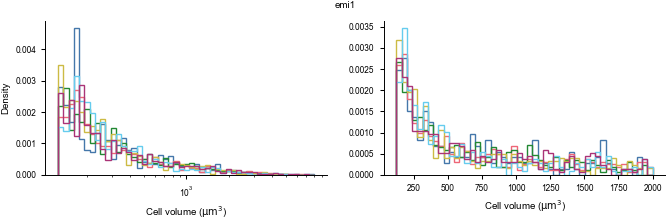

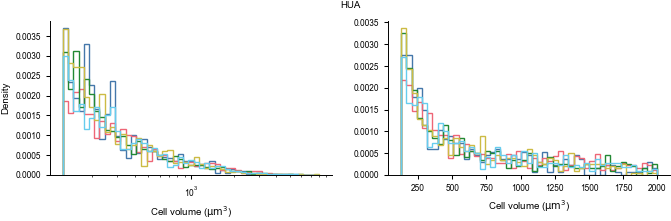

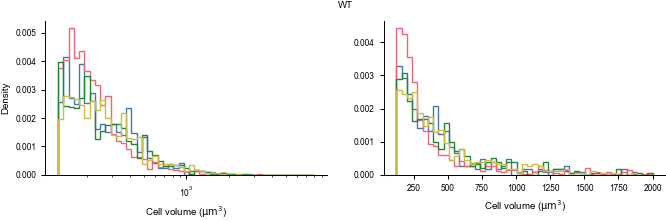

In [417]:
cell_size_min = 125
cell_size_max = 8000
n_bins = 50
cell_sizes_filtered = all_cell_sizes[(all_cell_sizes["volume_um3"] > cell_size_min) & (all_cell_sizes["volume_um3"] < cell_size_max)]
cell_sizes_by_sample = cell_sizes_filtered.set_index(["genotype", "idx"])

for genotype in cell_sizes_by_sample.index.unique("genotype"):
    fig, axs = plt.subplots(1,2, figsize=(8,2))
    curr_sizes = cell_sizes_by_sample.loc[genotype]
    for idx in curr_sizes.index.unique("idx"):
        axs[0].hist(curr_sizes.loc[idx, "volume_um3"], bins=np.logspace(np.log10(cell_size_min),
                                                                    np.log10(cell_size_max),base=10,num=n_bins), histtype="step", label=f"E{idx}", density=True)
        axs[0].set_xscale("log")
        axs[1].hist(curr_sizes.loc[idx, "volume_um3"], bins=np.linspace(cell_size_min,
                                                                    2000,n_bins), histtype="step", label=f"E{idx}", density=True)
        axs[0].set_ylabel("Density")
        axs[0].set_xlabel(r"Cell volume ($\mathrm{\mu m}^3$)")
        axs[1].set_xlabel(r"Cell volume ($\mathrm{\mu m}^3$)")
    fig.suptitle(genotype)
    fig.savefig(rootdir/"analysis"/f"{genotype}_cell_volume_histograms_{seg_output_dir}.svg")
cell_sizes_filtered.to_csv(rootdir/"analysis"/f"all_cell_volumes_filtered_{seg_output_dir}.csv", index=False)

In [ ]:
cell_sizes_by_sample = cell_sizes_filtered.set_index(["genotype", "idx"])
for idx in cell_sizes_by_sample.index.unique():
    # Print top 10 largest cells
    print(cell_sizes_by_sample.loc[idx].sort_values("volume_um3", ascending=False)[["volume_um3", "area"]].head(20))

In [ ]:
for genotype, idx in cell_sizes_by_sample.index.unique():
    visualize_filtered_segments(genotype, idx)

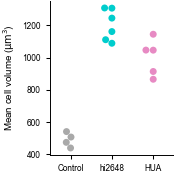

In [24]:
# For each sample, get the mean cell size
cell_sizes_by_sample = cell_sizes_filtered.set_index(["genotype", "idx"])
cell_size_means = cell_sizes_by_sample.groupby(["genotype", "idx"]).mean()
cell_size_means.to_csv(rootdir/"analysis"/"cell_size_means.csv", index=True)

fig1, ax1 = plt.subplots(figsize=(1.6,2))
order = ["Control", "hi2648", "HUA"]
sns.swarmplot(data=cell_size_means.reset_index(), x="genotype", y="volume_um3", ax=ax1, order=order, palette=palette)
ax1.set_xlabel("")
ax1.set_ylabel(r"Mean cell volume ($\mathrm{\mu m}^3$)")
fig1.savefig(rootdir/"analysis"/"mean_cell_volume_swarmplot.svg")

In [10]:
# Join to tissue volume data
seg_output_dir = "MutexWS_0.6_SP1000_minCell_14000"
expt_data = pd.read_csv(rootdir/"volume_data.csv")
expt_data["genotype"] = expt_data["genotype"].map({"WT": "Control", "emi1": "hi2648", "HUA": "HUA"})
expt_data = expt_data.set_index(["genotype", "idx"])

cell_sizes_filtered = pd.read_csv(rootdir/"analysis"/f"all_cell_volumes_filtered_{seg_output_dir}.csv")
cell_sizes_filtered["genotype"] = cell_sizes_filtered["genotype"].map({"WT": "Control", "emi1": "hi2648", "HUA": "HUA"})
cell_size_means = pd.read_csv(rootdir/"analysis"/"cell_size_means.csv").set_index(["genotype", "idx"])


expt_data.rename(columns={"volume_um3": "tissue_volume_um3", "voxel_size": "voxel_size_tissue"}, inplace=True)
cell_count_volume = cell_sizes_filtered.groupby(["genotype", "idx"]).agg(["sum", "count"])["volume_um3"]
cell_count_volume.rename(columns={"sum": "sample_volume", "count": "sample_n_cells"}, inplace=True)
expt_data = expt_data.join(cell_count_volume, on=["genotype", "idx"])
expt_data = expt_data.join(cell_size_means.rename(columns={"volume_um3":"cell_volume_um3"}), on=["genotype", "idx"])
expt_data["cell_number_est"] = expt_data["tissue_volume_um3"]/expt_data["sample_volume"]*expt_data["sample_n_cells"]

In [11]:
full_embryo_lengths = pd.read_csv(rootdir/"analysis"/"full_embryo_lengths.csv").rename(columns={"Length": "full_embryo_length_um"})
hindbrain_lengths = pd.read_csv(rootdir/"analysis"/"hindbrain_lengths.csv").rename(columns={"Length": "hindbrain_length_um"})
# Split label with format "genotype_Eidx" into separate columns
full_embryo_lengths[["genotype", "idx"]] = full_embryo_lengths["Label"].str.split("_", expand=True)
full_embryo_lengths["idx"] = full_embryo_lengths["idx"].apply(lambda x: x[1:]).astype(int)
full_embryo_lengths["genotype"] = full_embryo_lengths["genotype"].map({"WT": "Control", "emi1": "hi2648", "HUA": "HUA"})
full_embryo_lengths.set_index(["genotype", "idx"], inplace=True)
full_embryo_lengths = full_embryo_lengths[["full_embryo_length_um"]]
hindbrain_lengths[["genotype", "idx"]] = hindbrain_lengths["Label"].str.split("_", expand=True)
hindbrain_lengths["idx"] = hindbrain_lengths["idx"].apply(lambda x: x[1:]).astype(int)
hindbrain_lengths["genotype"] = hindbrain_lengths["genotype"].map({"WT": "Control", "emi1": "hi2648", "HUA": "HUA"})
hindbrain_lengths.set_index(["genotype", "idx"], inplace=True)
expt_data = expt_data.join(full_embryo_lengths, on=["genotype", "idx"])
expt_data = expt_data.join(hindbrain_lengths, on=["genotype", "idx"])

In [12]:
expt_data.drop(columns=["label", "sample_volume", "area", "centroid-0", "centroid-1", "centroid-2", "Area", "Angle", " "], inplace=True)
expt_data.to_csv(rootdir/"analysis"/"combined_sample_data.csv", index=True)
expt_data.reset_index().groupby("genotype").agg(["mean", "median"])["cell_number_est"]

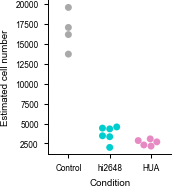

In [29]:
fig1, ax1 = plt.subplots(figsize=(1.6,2))
order = ["Control", "hi2648", "HUA"]
sns.swarmplot(data=expt_data.reset_index(), x="genotype", y="cell_number_est", ax=ax1, order=order, palette=palette)
ax1.set_xlabel("Condition")
ax1.set_ylabel(r"Estimated cell number")
plt.savefig(rootdir/"analysis"/"cell_number_swarmplot.svg")